In [2]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from svd_compression import calculate_singular_values, compress_matrix

In [3]:
def random_matrix(n, p=0):
    r_matrix = np.random.uniform(0, 1, (n, n))
    for ind in np.random.permutation(range(n*n))[:int(n*n*p)]:
        r_matrix[ind // n, ind % n] = 0
    return r_matrix

In [15]:
def plot_singular_values(values):
    plt.title('Singular values')
    plt.plot(values)

In [12]:
eps = 1e-12

[[0.         0.         0.         ... 0.98807448 0.         0.        ]
 [0.         0.09106755 0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


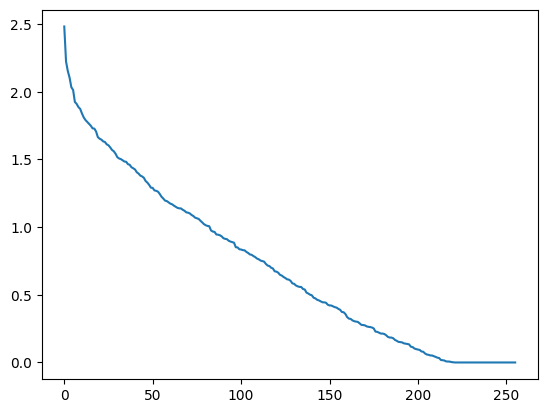

In [23]:
mat = random_matrix(256, 0.99)
v = calculate_singular_values(mat)
plot_singular_values(v)
print(mat)

In [24]:
image_mat = np.full((256, 256), 255)
tree = compress_matrix(mat, v[128], 4)
image = Image.fromarray(image_mat)

In [25]:
mat2 = tree.eval()
print(np.max(mat2 - mat))

0.29305698813373054


In [26]:
from Tree import InternalNode, Leaf

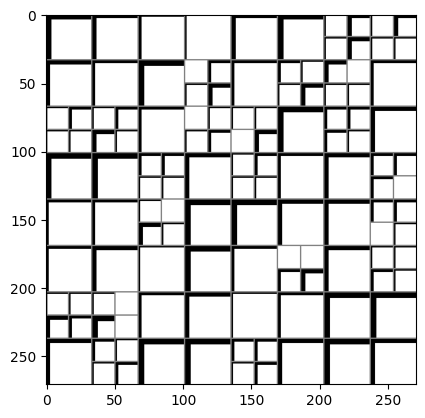

In [32]:
plt.imshow(image)
plt.gray()
plt.show()

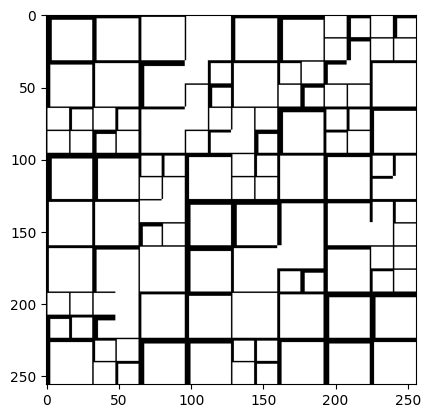

In [35]:
plt.imshow(Image.fromarray(tree.draw()))

W sumie to samo wyszło

# Testy

In [17]:
import time

In [8]:
size = 2 ** 10
zeros_percentage = [0.99, 0.98, 0.95, 0.9, 0.8]

In [32]:
results = []

Zeros percentage: 99.0 %


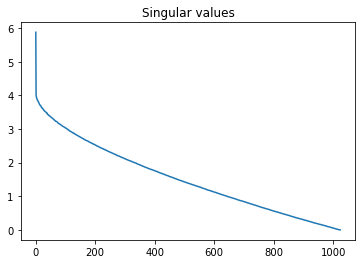

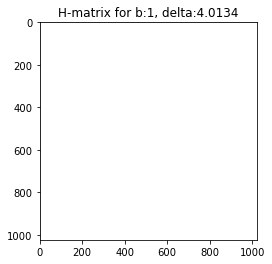

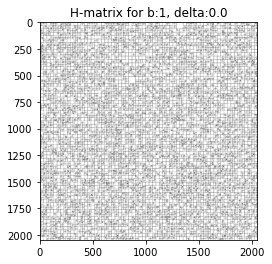

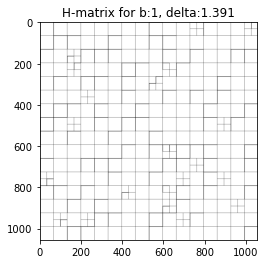

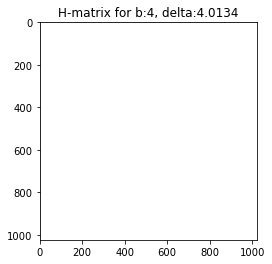

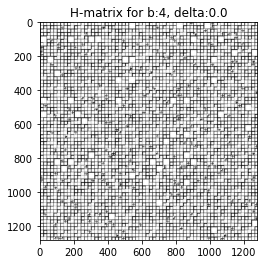

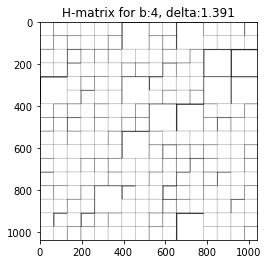

Zeros percentage: 98.0 %


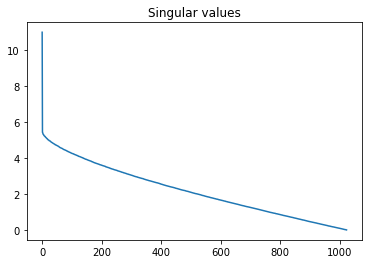

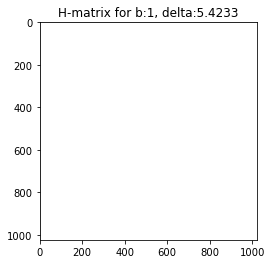

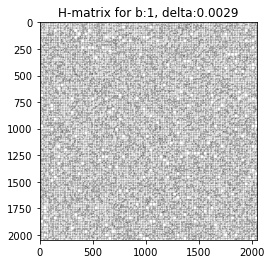

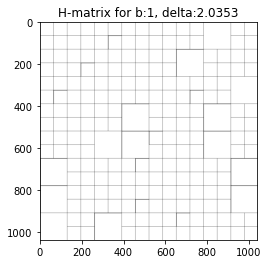

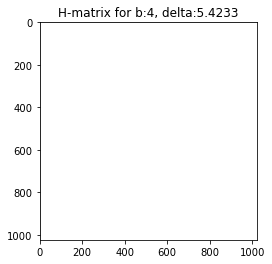

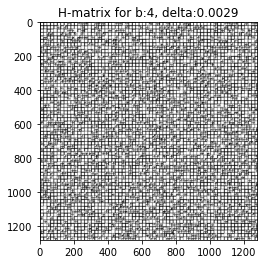

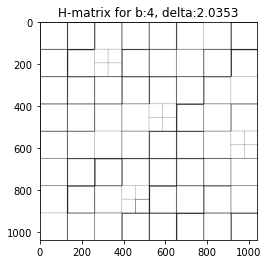

Zeros percentage: 95.0 %


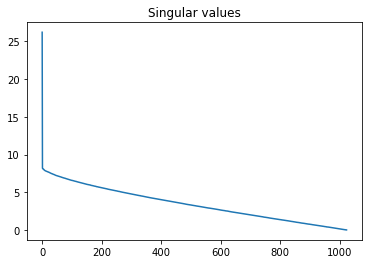

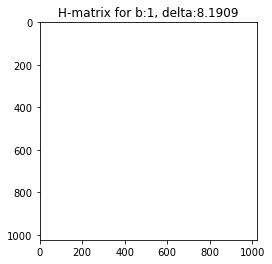

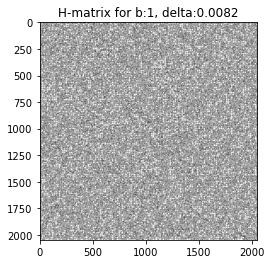

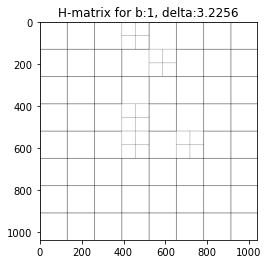

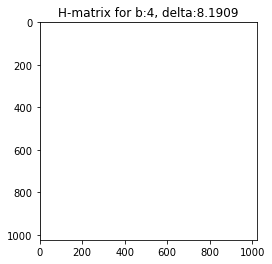

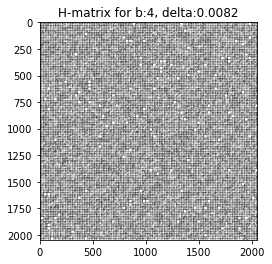

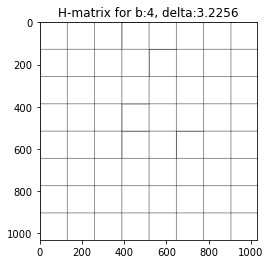

Zeros percentage: 90.0 %


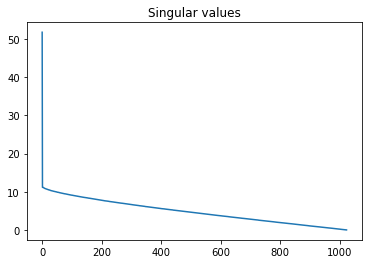

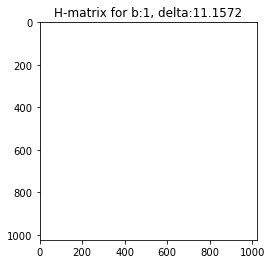

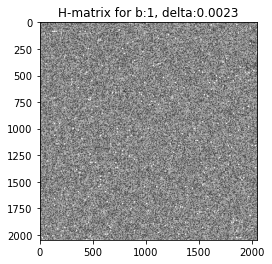

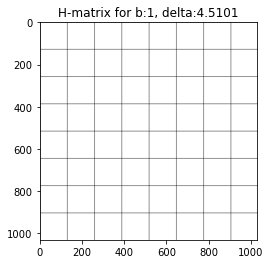

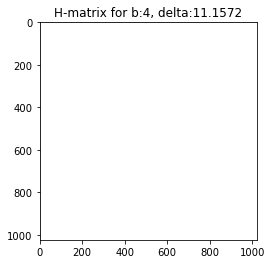

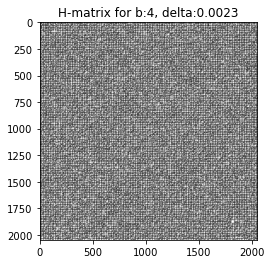

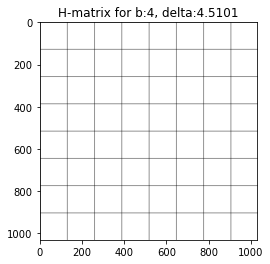

Zeros percentage: 80.0 %


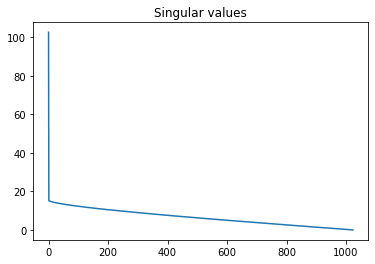

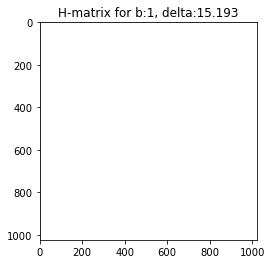

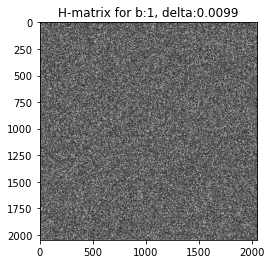

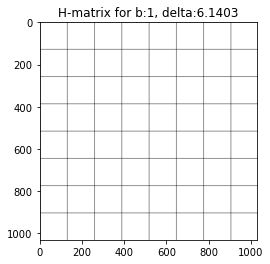

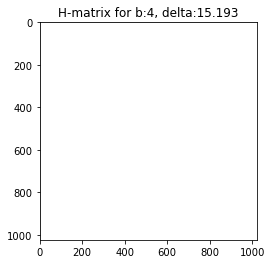

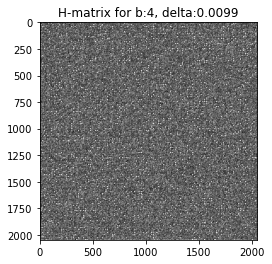

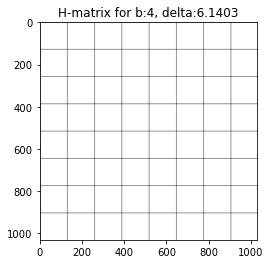

In [33]:
for zeros_p in zeros_percentage:
    print('Zeros percentage:', zeros_p * 100, '%')
    matrix = random_matrix(size, zeros_p)
    
    singular_values = calculate_singular_values(matrix)
    
    plot_singular_values(singular_values)
    plt.show()
    
    b_values = [1, 4]
    delta_values = [singular_values[1], singular_values[-1], singular_values[len(singular_values) // 2]]
    
    for b in b_values:
        for delta in delta_values:
            time_start = time.time()
            root = compress_matrix(matrix, delta, b)
            time_stop = time.time()
            
            image = root.draw()
            plt.imshow(image)
            plt.title(f'H-matrix for b:{b}, delta:{round(delta, 4)}')
            plt.gray()
            plt.show()
            
            decompressed_matrix = root.eval()
            norm = np.linalg.norm(matrix - decompressed_matrix) ** 2
            
            results.append((zeros_p, b, delta, time_stop - time_start, norm))

In [36]:
import pandas as pd

dataframe = pd.DataFrame(results, columns=['Zeros number', 'Max rank', 'Delta', 'Compress time', 'Norm of difference'])

print(dataframe)

    Zeros number  Max rank         Delta  Compress time  Norm of difference
0           0.99         1  4.013442e+00       0.090562        3.415914e+03
1           0.99         1  2.042159e-15      11.324494        6.450321e-11
2           0.99         1  1.391032e+00       2.520987        3.239725e+03
3           0.99         4  4.013442e+00       0.078112        3.415914e+03
4           0.99         4  2.042159e-15       6.607527        6.450321e-11
5           0.99         4  1.391032e+00       2.935542        3.098131e+03
6           0.98         1  5.423268e+00       0.080619        6.897282e+03
7           0.98         1  2.871912e-03      16.719181        1.366266e-04
8           0.98         1  2.035313e+00       2.502074        6.937630e+03
9           0.98         4  5.423268e+00       0.100244        6.897282e+03
10          0.98         4  2.871912e-03       9.577166        1.282799e-04
11          0.98         4  2.035313e+00       2.721845        6.361360e+03
12          